In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.plot
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

# Evaluate bias

In [3]:
basedir = '/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/'

Pon    = sak.load_data(os.path.join(basedir,'Pon.csv'))
Poff   = sak.load_data(os.path.join(basedir,'Poff.csv'))
QRSon  = sak.load_data(os.path.join(basedir,'QRSon.csv'))
QRSoff = sak.load_data(os.path.join(basedir,'QRSoff.csv'))
Ton    = sak.load_data(os.path.join(basedir,'Ton.csv'))
Toff   = sak.load_data(os.path.join(basedir,'Toff.csv'))

N_Pwaves = sum([Pon[k].size for k in Pon])
N_QRSwaves = sum([QRSon[k].size for k in QRSon])
N_Twaves = sum([Ton[k].size for k in Ton])

In [4]:
P_bias_on_95 = []
P_bias_off_95 = []
QRS_bias_on_95 = []
QRS_bias_off_95 = []
T_bias_on_95 = []
T_bias_off_95 = []

P_bias_on_99 = []
P_bias_off_99 = []
QRS_bias_on_99 = []
QRS_bias_off_99 = []
T_bias_on_99 = []
T_bias_off_99 = []

for file in tqdm.tqdm(glob.glob('/media/guille/DADES/DADES/DelineationResults/BIAS_0_SEPARATE/*/*.csv')):
    root,fname = os.path.split(file)
    
    # Select wave
    wave = fname.split("_")[0]
    
    # Retrieve associated outputs
    wave_on_95  = eval("{}_bias_on_95".format(wave))
    wave_off_95 = eval("{}_bias_off_95".format(wave))
    wave_on_99  = eval("{}_bias_on_99".format(wave))
    wave_off_99 = eval("{}_bias_off_99".format(wave))
    
    # Load bias data
    bias = sak.load_data(file,start_dim=2)
    
    for b in bias:
        if b.split(",")[1] ==  "onsets95":  wave_on_95.append(bias[b])
        if b.split(",")[1] == "offsets95": wave_off_95.append(bias[b])
        if b.split(",")[1] ==  "onsets99":  wave_on_99.append(bias[b])
        if b.split(",")[1] == "offsets99": wave_off_99.append(bias[b])

# Convert to arrays for metrics            
P_bias_on_95 = np.concatenate(P_bias_on_95)
P_bias_off_95 = np.concatenate(P_bias_off_95)
QRS_bias_on_95 = np.concatenate(QRS_bias_on_95)
QRS_bias_off_95 = np.concatenate(QRS_bias_off_95)
T_bias_on_95 = np.concatenate(T_bias_on_95)
T_bias_off_95 = np.concatenate(T_bias_off_95)

P_bias_on_99 = np.concatenate(P_bias_on_99)
P_bias_off_99 = np.concatenate(P_bias_off_99)
QRS_bias_on_99 = np.concatenate(QRS_bias_on_99)
QRS_bias_off_99 = np.concatenate(QRS_bias_off_99)
T_bias_on_99 = np.concatenate(T_bias_on_99)
T_bias_off_99 = np.concatenate(T_bias_off_99)


100%|██████████| 21060/21060 [01:51<00:00, 189.47it/s]


In [5]:
for p in ["95","99"]:
    for wave in ['P','QRS','T']:
        print("############ {} WAVE, {}% ############".format(wave,p))

        # Retrieve associated outputs
        wave_on  = eval("{}_bias_on_{}".format(wave,p))
        wave_off = eval("{}_bias_off_{}".format(wave,p))

        # Print delineation bias
        print("ONSET ERROR  ->  MEAN: {} ms, STD: {} ms".format(np.round(np.mean(wave_on)*4,2),np.round(np.std(wave_on)*4,2),))
        print("OFFSET ERROR ->  MEAN: {} ms, STD: {} ms".format(np.round(np.mean(wave_off)*4,2),np.round(np.std(wave_off)*4,2),))
        print("Matches {} wave: {}%".format(wave,np.round(100*wave_on.size/(N_Pwaves**2),2)))
        print("")
        
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

############ P WAVE, 95% ############
ONSET ERROR  ->  MEAN: -5.16 ms, STD: 37.58 ms
OFFSET ERROR ->  MEAN: -1.23 ms, STD: 38.83 ms
Matches P wave: 30.46%

############ QRS WAVE, 95% ############
ONSET ERROR  ->  MEAN: 2.99 ms, STD: 41.77 ms
OFFSET ERROR ->  MEAN: 12.53 ms, STD: 42.0 ms
Matches QRS wave: 19.88%

############ T WAVE, 95% ############
ONSET ERROR  ->  MEAN: -43.31 ms, STD: 91.19 ms
OFFSET ERROR ->  MEAN: -12.62 ms, STD: 77.13 ms
Matches T wave: 49.52%

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

############ P WAVE, 99% ############
ONSET ERROR  ->  MEAN: -11.35 ms, STD: 46.57 ms
OFFSET ERROR ->  MEAN: 1.35 ms, STD: 46.92 ms
Matches P wave: 0.89%

############ QRS WAVE, 99% ############
ONSET ERROR  ->  MEAN: -14.85 ms, STD: 42.42 ms
OFFSET ERROR ->  MEAN: 14.69 ms, STD: 44.98 ms
Matches QRS wave: 0.31%

############ T WAVE, 99% ############
ONSET ERROR  ->  MEAN: -51.36 ms, STD: 76.59 ms
OFFSET ERROR ->  MEAN: 5.47 ms, STD: 49.76 ms
Matches T wave: 11.94%

~

# Compare to maños

In [3]:
basedir = '/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/'

# Dataset
dataset = pd.read_csv(os.path.join(basedir,'Dataset.csv'), index_col=0)
dataset = dataset.sort_index(axis=1)

# Validity
try:
    validity = sak.load_data(os.path.join(basedir,'validity.csv'))
    appendage = "New"
    # Convert to old-style format
    val_tmp = {}
    for k in validity:
        val_tmp[k] = {}
        val_tmp[k]["on"] = [validity[k][0]]
        val_tmp[k]["off"] = [validity[k][1]]
    for k in ['sel35','sel36','sel103','sel232','sel310']:
        val_tmp[k+'_0'] = {}
        val_tmp[k+'_1'] = {}
        val_tmp[k+'_0']["on"] = []
        val_tmp[k+'_1']["on"] = []
        val_tmp[k+'_0']["off"] = []
        val_tmp[k+'_1']["off"] = []
    validity = pd.DataFrame(val_tmp)
        
except FileNotFoundError:
    validity = pd.read_csv(os.path.join(basedir,'Validity.csv'), index_col=0, 
                           converters={"on": eval, "off": eval}).T
    appendage = ""
    
# Fiducials
Pon    = sak.load_data(os.path.join(basedir,'Pon{}.csv'.format(appendage)))
Poff   = sak.load_data(os.path.join(basedir,'Poff{}.csv'.format(appendage)))
QRSon  = sak.load_data(os.path.join(basedir,'QRSon{}.csv'.format(appendage)))
QRSoff = sak.load_data(os.path.join(basedir,'QRSoff{}.csv'.format(appendage)))
Ton    = sak.load_data(os.path.join(basedir,'Ton{}.csv'.format(appendage)))
Toff   = sak.load_data(os.path.join(basedir,'Toff{}.csv'.format(appendage)))


In [4]:
truepositive = {'P': [], 'QRS': [], 'T': []}
falsepositive = {'P': [], 'QRS': [], 'T': []}
falsenegative = {'P': [], 'QRS': [], 'T': []}
dicescore = {'P': [], 'QRS': [], 'T': []}
onseterrors = {'P': [], 'QRS': [], 'T': []}
offseterrors = {'P': [], 'QRS': [], 'T': []}


for file in tqdm.tqdm(glob.glob('/media/guille/DADES/DADES/DelineationResults/MANYOS/*')):
    root,fname = os.path.split(file)
    k,ext = os.path.splitext(fname)
    
    # Retrieve validity regions
    onsets,offsets = validity[k]
    
    # Load predictions
    predictions = pd.read_csv(file)
    PredictedPon = predictions['Pon'].values
    PredictedPoff = predictions['Poff'].values
    PredictedQRSon = predictions['QRSon'].values
    PredictedQRSoff = predictions['QRSoff'].values
    PredictedTon = predictions['Ton'].values
    PredictedToff = predictions['Toff'].values

    for on,off in zip(onsets,offsets):
        for wave in ['P', 'QRS', 'T']:
            # Get predictions and targets
            input_wave_on = eval("Predicted{}on".format(wave))
            input_wave_off = eval("Predicted{}off".format(wave))
            target_wave_on = eval("{}on".format(wave))[k]
            target_wave_off = eval("{}off".format(wave))[k]
            
            # Refine inputs given nans
            filternotnan = ~(np.isnan(input_wave_on) | np.isnan(input_wave_off))
            input_wave_on = input_wave_on[filternotnan].astype(int)
            input_wave_off = input_wave_off[filternotnan].astype(int)
            
            # Refine in validity regions
            input_wave_on,input_wave_off = src.metrics.filter_valid(input_wave_on,input_wave_off,on,off)
            target_wave_on,target_wave_off = src.metrics.filter_valid(target_wave_on,target_wave_off,on,off)
            
            # Compute metrics
            tp,fp,fn,dice,onerror,offerror = src.metrics.compute_metrics(input_wave_on,input_wave_off,target_wave_on,target_wave_off)
            
            # Store metrics
            truepositive[wave].append(tp)
            falsepositive[wave].append(fp)
            falsenegative[wave].append(fn)
            dicescore[wave].append(dice)
            onseterrors[wave] += onerror
            offseterrors[wave] += offerror


100%|██████████| 210/210 [00:03<00:00, 57.23it/s]


In [5]:
wave = 'P'
for wave in ['P', 'QRS', 'T']:
    print("################ {} WAVE ################".format(wave))
    print("precision: {}%".format(np.round(src.metrics.precision(sum(truepositive[wave]),sum(falsepositive[wave]),sum(falsenegative[wave]))*100,2)))
    print("recall:    {}%".format(np.round(src.metrics.recall(sum(truepositive[wave]),sum(falsepositive[wave]),sum(falsenegative[wave]))*100,2)))
    print("onerror:   {} ± {} ms".format(np.round(np.mean(onseterrors[wave])*4,2),np.round(np.std(onseterrors[wave])*4,2)))
    print("offerror:  {} ± {} ms".format(np.round(np.mean(offseterrors[wave])*4,2),np.round(np.std(offseterrors[wave])*4,2)))
    print("")

################ P WAVE ################
precision: 87.48%
recall:    75.13%
onerror:   15.61 ± 50.16 ms
offerror:  16.32 ± 32.72 ms

################ QRS WAVE ################
precision: 93.5%
recall:    98.79%
onerror:   13.32 ± 24.14 ms
offerror:  -35.48 ± 27.1 ms

################ T WAVE ################
precision: 93.12%
recall:    91.8%
onerror:   -68.13 ± 64.13 ms
offerror:  -9.45 ± 49.97 ms



In [26]:
### MULTI-LEAD ###
truepositive = {'P': [], 'QRS': [], 'T': []}
falsepositive = {'P': [], 'QRS': [], 'T': []}
falsenegative = {'P': [], 'QRS': [], 'T': []}
dicescore = {'P': [], 'QRS': [], 'T': []}
onseterrors = {'P': [], 'QRS': [], 'T': []}
offseterrors = {'P': [], 'QRS': [], 'T': []}

unique_ids = list(set([os.path.splitext(os.path.split(f)[1])[0].split('_')[0] for f in glob.glob('/media/guille/DADES/DADES/DelineationResults/MANYOS/*')]))

for k in tqdm.tqdm(unique_ids):
    # File names
    file_0 = os.path.join('/media/guille/DADES/DADES/DelineationResults/MANYOS/',"{}_0.txt".format(k))
    file_1 = os.path.join('/media/guille/DADES/DADES/DelineationResults/MANYOS/',"{}_1.txt".format(k))
    
    # Retrieve validity regions
    onsets,offsets = validity[k+'_0']
    
    # Load predictions
    predictions_0 = pd.read_csv(file_0)
    PredictedPon_0 = predictions_0['Pon'].values
    PredictedPoff_0 = predictions_0['Poff'].values
    PredictedQRSon_0 = predictions_0['QRSon'].values
    PredictedQRSoff_0 = predictions_0['QRSoff'].values
    PredictedTon_0 = predictions_0['Ton'].values
    PredictedToff_0 = predictions_0['Toff'].values
    
    predictions_1 = pd.read_csv(file_1)
    PredictedPon_1 = predictions_1['Pon'].values
    PredictedPoff_1 = predictions_1['Poff'].values
    PredictedQRSon_1 = predictions_1['QRSon'].values
    PredictedQRSoff_1 = predictions_1['QRSoff'].values
    PredictedTon_1 = predictions_1['Ton'].values
    PredictedToff_1 = predictions_1['Toff'].values
    
    for on,off in zip(onsets,offsets):
        for wave in ['P', 'QRS', 'T']:
            # Get predictions and targets
            input_wave_on_0 = eval("Predicted{}on_0".format(wave))
            input_wave_off_0 = eval("Predicted{}off_0".format(wave))
            input_wave_on_1 = eval("Predicted{}on_1".format(wave))
            input_wave_off_1 = eval("Predicted{}off_1".format(wave))
            target_wave_on = eval("{}on".format(wave))[k+'_0']
            target_wave_off = eval("{}off".format(wave))[k+'_0']
            
            # Refine inputs given nans
            filternotnan_0 = ~(np.isnan(input_wave_on_0) | np.isnan(input_wave_off_0))
            input_wave_on_0 = input_wave_on_0[filternotnan_0].astype(int)
            input_wave_off_0 = input_wave_off_0[filternotnan_0].astype(int)
            
            filternotnan_1 = ~(np.isnan(input_wave_on_1) | np.isnan(input_wave_off_1))
            input_wave_on_1 = input_wave_on_1[filternotnan_1].astype(int)
            input_wave_off_1 = input_wave_off_1[filternotnan_1].astype(int)
            
            # Refine in validity regions
            input_wave_on_0,input_wave_off_0 = src.metrics.filter_valid(input_wave_on_0,input_wave_off_0,on,off)
            input_wave_on_1,input_wave_off_1 = src.metrics.filter_valid(input_wave_on_1,input_wave_off_1,on,off)
            target_wave_on,target_wave_off = src.metrics.filter_valid(target_wave_on,target_wave_off,on,off)
            
            # Compute metrics
            tp,fp,fn,dice,onerror,offerror = src.metrics.compute_QTDB_metrics(input_wave_on_0,input_wave_off_0,input_wave_on_1,input_wave_off_1,target_wave_on,target_wave_off)
            
            # Store metrics
            truepositive[wave].append(tp)
            falsepositive[wave].append(fp)
            falsenegative[wave].append(fn)
            dicescore[wave].append(dice)
            onseterrors[wave] += onerror
            offseterrors[wave] += offerror


100%|██████████| 105/105 [00:01<00:00, 64.74it/s]


In [27]:
wave = 'P'
for wave in ['P', 'QRS', 'T']:
    print("################ {} WAVE ################".format(wave))
    print("precision: {}%".format(np.round(src.metrics.precision(sum(truepositive[wave]),sum(falsepositive[wave]),sum(falsenegative[wave]))*100,2)))
    print("recall:    {}%".format(np.round(src.metrics.recall(sum(truepositive[wave]),sum(falsepositive[wave]),sum(falsenegative[wave]))*100,2)))
    print("onerror:   {} ± {} ms".format(np.round(np.mean(onseterrors[wave])*4,2),np.round(np.std(onseterrors[wave])*4,2)))
    print("offerror:  {} ± {} ms".format(np.round(np.mean(offseterrors[wave])*4,2),np.round(np.std(offseterrors[wave])*4,2)))
    print("")

################ P WAVE ################
precision: 85.45%
recall:    88.81%
onerror:   9.94 ± 40.62 ms
offerror:  13.82 ± 27.95 ms

################ QRS WAVE ################
precision: 91.94%
recall:    99.88%
onerror:   9.06 ± 16.4 ms
offerror:  -27.94 ± 19.2 ms

################ T WAVE ################
precision: 91.38%
recall:    98.78%
onerror:   -58.3 ± 53.2 ms
offerror:  -7.49 ± 34.24 ms



# Inter-observer variability

In [64]:
PonO1    = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/Pon.csv')
PoffO1   = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/Poff.csv')
QRSonO1  = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/QRSon.csv')
QRSoffO1 = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/QRSoff.csv')
TonO1    = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/Ton.csv')
ToffO1   = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/Toff.csv')

PonO2    = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual1/Pon.csv')
PoffO2   = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual1/Poff.csv')
QRSonO2  = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual1/QRSon.csv')
QRSoffO2 = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual1/QRSoff.csv')
TonO2    = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual1/Ton.csv')
ToffO2   = sak.load_data('/media/guille/DADES/DADES/PhysioNet/QTDB/manual1/Toff.csv')

In [74]:
onseterrors = {'P': [], 'QRS': [], 'T': []}
offseterrors = {'P': [], 'QRS': [], 'T': []}

for k in QRSonO1:
    for wave in ['P','QRS','T']:
        # Load inputs, targets
        input_onset = eval("{}onO1".format(wave))[k]
        input_offset = eval("{}offO1".format(wave))[k]
        target_onset = eval("{}onO2".format(wave))[k]
        target_offset = eval("{}offO2".format(wave))[k]
        
        if (target_onset.size == 0) or (target_offset.size == 0):
            continue
        
        # Compute metrics
        _,_,_,_,onerror,offerror = src.metrics.compute_metrics(input_onset,input_offset,target_onset,target_offset)

        # Store metrics
        onseterrors[wave] += onerror
        offseterrors[wave] += offerror


In [75]:
wave = 'P'
for wave in ['P', 'QRS', 'T']:
    print("################ {} WAVE ################".format(wave))
    print("onerror:   {} ± {} ms".format(np.round(np.mean(onseterrors[wave])*4,2),np.round(np.std(onseterrors[wave])*4,2)))
    print("offerror:  {} ± {} ms".format(np.round(np.mean(offseterrors[wave])*4,2),np.round(np.std(offseterrors[wave])*4,2)))
    print("")

################ P WAVE ################
onerror:   nan ± nan ms
offerror:  nan ± nan ms

################ QRS WAVE ################
onerror:   3.84 ± 14.17 ms
offerror:  2.74 ± 16.94 ms

################ T WAVE ################
onerror:   -9.52 ± 44.85 ms
offerror:  5.84 ± 39.84 ms



/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/guille/VirtEnv/DeepLearning3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Load database

In [3]:
# basedir = '/media/guille/DADES/DADES/Delineator/QTDB/'
basedir = '/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/'

# Dataset
dataset = pd.read_csv(os.path.join(basedir,'Dataset.csv'), index_col=0)
dataset = dataset.sort_index(axis=1)

# Validity
try:
    validity = sak.load_data(os.path.join(basedir,'validity.csv'))
    appendage = "New"
    # Convert to old-style format
    val_tmp = {}
    for k in validity:
        val_tmp[k] = {}
        val_tmp[k]["on"] = [validity[k][0]]
        val_tmp[k]["off"] = [validity[k][1]]
    for k in ['sel35','sel36','sel103','sel232','sel310']:
        val_tmp[k+'_0'] = {}
        val_tmp[k+'_1'] = {}
        val_tmp[k+'_0']["on"] = []
        val_tmp[k+'_1']["on"] = []
        val_tmp[k+'_0']["off"] = []
        val_tmp[k+'_1']["off"] = []
    validity = pd.DataFrame(val_tmp)
        
except FileNotFoundError:
    validity = pd.read_csv(os.path.join(basedir,'Validity.csv'), index_col=0, 
                           converters={"on": eval, "off": eval}).T
    appendage = ""
    
# Fiducials
Pon    = sak.load_data(os.path.join(basedir,'Pon{}.csv'.format(appendage)))
Poff   = sak.load_data(os.path.join(basedir,'Poff{}.csv'.format(appendage)))
QRSon  = sak.load_data(os.path.join(basedir,'QRSon{}.csv'.format(appendage)))
QRSoff = sak.load_data(os.path.join(basedir,'QRSoff{}.csv'.format(appendage)))
Ton    = sak.load_data(os.path.join(basedir,'Ton{}.csv'.format(appendage)))
Toff   = sak.load_data(os.path.join(basedir,'Toff{}.csv'.format(appendage)))

# Add all to validity
for k in QRSon:
    if k not in validity:
        validity = validity.to_dict()
        validity[k] = {"on": [], "off": []}
        validity = pd.DataFrame(validity)
        
# Exclude validity sections smaller than N = 2048
for k in validity:
    exclude = []
    for i,(on,off) in enumerate(zip(*validity[k])):
        if off-on < 2048:
            exclude.append(i)
    # Sort list
    exclude = np.sort(exclude)[::-1]
    if len(exclude) > 0:
        for pos in exclude:
            validity = validity.to_dict()
            validity[k]["on"].pop(pos)
            validity[k]["off"].pop(pos)
            validity = pd.DataFrame(validity)

sele0133_1


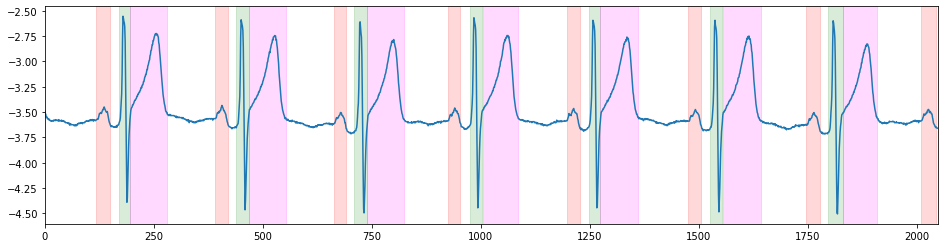

In [376]:
k = np.random.choice(list(dataset))
# k = 'sel30_0'
# k = 'sel16539_0'
# k = 'sel853_0'
k = 'sele0133_1'
for on,off in zip(*validity[k]):
    signal = dataset[k].values[on:on+2048]
    mask = np.zeros((3,signal.size),dtype=bool)
    pon,poff     = Pon[k]-on,Poff[k]-on
    qrson,qrsoff = QRSon[k]-on,QRSoff[k]-on
    ton,toff     = Ton[k]-on,Toff[k]-on
    
    for i,j in zip(pon,poff):
        mask[0,i:j] = 1
    for i,j in zip(qrson,qrsoff):
        mask[1,i:j] = 1
    for i,j in zip(ton,toff):
        mask[2,i:j] = 1
    pass
print(k)
sak.visualization.plot.segmentation(signal,mask)
plt.xlim([0,2048])
plt.savefig(os.path.expanduser("~/sig_mask.svg"))

sel230_1


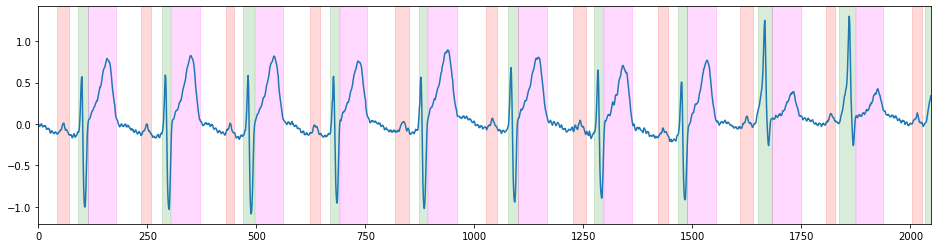

In [375]:
k2 = np.random.choice(list(dataset))
# k2 = 'sel104_0'
# k2 = 'sel36_0'
# k2 = 'sel16539_0'
# k2 = 'sel16420_0'
# k2 = 'sel233_0'
k2 = 'sel230_1'
for on,off in zip(*validity[k2]):
    signal2 = dataset[k2].values[on:on+2048]
    mask2 = np.zeros((3,signal2.size),dtype=bool)
    pon2,poff2     = Pon[k2]-on,Poff[k2]-on
    qrson2,qrsoff2 = QRSon[k2]-on,QRSoff[k2]-on
    ton2,toff2     = Ton[k2]-on,Toff[k2]-on
    for i,j in zip(pon2,poff2):
        mask2[0,i:j] = 1
    for i,j in zip(qrson2,qrsoff2):
        mask2[1,i:j] = 1
    for i,j in zip(ton2,toff2):
        mask2[2,i:j] = 1
print(k2)
sak.visualization.plot.segmentation(signal2,mask2)
plt.xlim([0,2048])
plt.savefig(os.path.expanduser("~/sig_comparison.svg"))

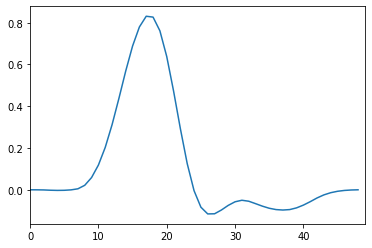

In [403]:
for i,j in zip(qrson,qrsoff):
    fundamental = sak.signal.on_off_correction(signal[i:j])
    break
    
for i,j in zip(qrson2,qrsoff2):
    if j >= 2048: break
    comparison = sak.signal.on_off_correction(signal2[i:j])
    pass
    
c,l=sak.signal.xcorr(fundamental,comparison[7:-7])#,maxlags=0)

plt.plot(c)
plt.xlim([0,c.size])
plt.savefig(os.path.expanduser("~/correlation.svg"))


In [406]:
c.max()

0.8307585036567834

In [401]:
fundamental.size

25

In [402]:
comparison.size

39

In [372]:
windowed_k2 = skimage.util.view_as_windows(signal2,fundamental.size)
filt = np.zeros((windowed_k2.shape[0],),dtype=bool)
for on,off in zip(qrson2-(fundamental.size+1),qrsoff2+(fundamental.size-1)):
    filt[on:off] = True

# Compute correlations
corrs = np.zeros((windowed_k2.shape[0],))
for j,w in enumerate(windowed_k2):
    if not filt[j]: continue
    # Correct deviations w.r.t zero
    w = sak.signal.on_off_correction(w)
    c,_ = sak.signal.xcorr(fundamental,w,maxlags=0)
    corrs[j] = c

mask99 = np.array(corrs) > 0.9
mask99 = cv2.morphologyEx(mask99.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)


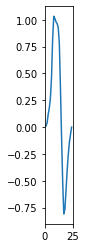

In [373]:
plt.figure(figsize=(0.5,4))
plt.plot(fundamental)
plt.xlim([0,fundamental.size])
plt.savefig(os.path.expanduser("~/fundamental.svg"))


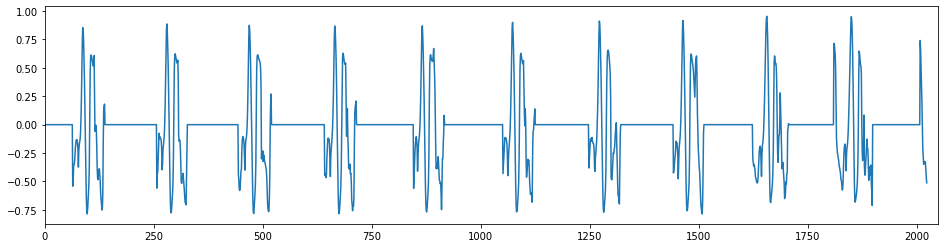

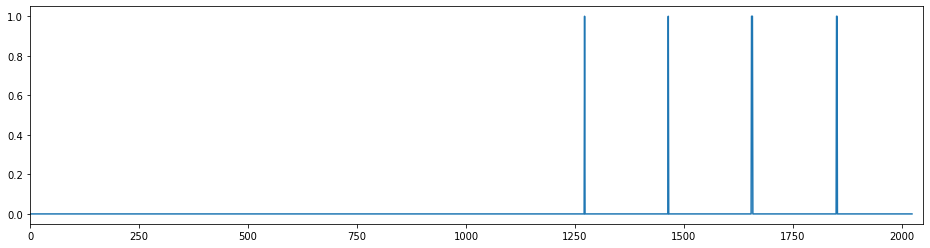

In [374]:
plt.figure(figsize=(16,4))
plt.plot(corrs)
plt.xlim([0,2048])
plt.savefig(os.path.expanduser("~/allcorrelations.svg"))

plt.figure(figsize=(16,4))
plt.plot(mask99)
plt.xlim([0,2048])
plt.savefig(os.path.expanduser("~/locations.svg"))


#### Step 1: normalize database

In [4]:
for k in tqdm.tqdm(list(dataset)):
    if (len(validity[k]['on']) == 0) or (len(validity[k]['off']) == 0):
        continue
    # Copy signal just in case
    signal = np.copy(dataset[k].values)
    
    # Filter signal
    signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250., 'high'),signal.T).T
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 125.0/250.,  'low'),signal.T).T

    # Normalize and pad signal for inputing in algorithm
    normalization = np.median(sak.signal.moving_lambda(signal,256,sak.signal.abs_max))
    signal = signal/normalization
    
    # Store in dataset
    dataset[k] = signal


100%|██████████| 210/210 [00:02<00:00, 84.89it/s]


#### Step 2: Check list of files

In [5]:
sig_names = []

for k in QRSon:
    max_n = max([len(Pon[k]),len(QRSon[k]),len(Ton[k])])
    for i in range(max_n):
        sig_names.append("{}-{}".format(k,i))

#### Step 3: Iterate over fundamentals

In [6]:
# Provided
i = np.random.randint(len(sig_names))

In [48]:
# Retrieve 
k1,i = sig_names[i].split('-')
i = int(i)

for wave in ['P', 'QRS', 'T']:
    # Retrieve waves
    wave_on = eval("{}on".format(wave))
    wave_off = eval("{}off".format(wave))
    
    # Retrieve fundamental
    if i >= len(wave_on[k1]): continue
    fundamental = dataset[k1][wave_on[k1][i]:wave_off[k1][i]].values
    fundamental = sak.signal.on_off_correction(fundamental)
    
    for k2 in tqdm.tqdm(dataset,total=dataset.shape[1]):
        # if the specific wave has nothing for the key, pass
        if k2 not in wave_on: continue

        # Define output structures
        onsets95 = []
        offsets95 = []
        onsets99 = []
        offsets99 = []
        correlations = []

        for valid_on,valid_off in zip(*validity[k2]):
            # Retrieve data
            target_onset,target_offset = src.metrics.filter_valid(wave_on[k2],wave_off[k2],valid_on,valid_off)
            target_onset -= valid_on
            target_offset -= valid_on
            
            # Skip if no available target delineations
            if target_onset.size == 0: continue
            
            # Retrieve signal
            signal = np.copy(dataset[k2].values[valid_on:valid_off])
                
            # Obtain windowing
            windowed_k2 = skimage.util.view_as_windows(signal,fundamental.size)
            filt = np.zeros((windowed_k2.shape[0],),dtype=bool)
            for on,off in zip(target_onset-(fundamental.size+1),target_offset+(fundamental.size-1)):
                filt[on:off] = True

            # Compute correlations
            corrs = np.zeros((windowed_k2.shape[0],))
            for j,w in enumerate(windowed_k2):
                if not filt[j]: continue
                # Correct deviations w.r.t zero
                w = sak.signal.on_off_correction(w)
                c,_ = sak.signal.xcorr(fundamental,w,maxlags=0)
                corrs[j] = c

            # Predict mask - threshold 95%
            mask95 = np.array(corrs) > 0.95
            mask95 = cv2.morphologyEx(mask95.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
            input_onset95 = []
            input_offset95 = []
            for on,off in zip(*sak.signal.get_mask_boundary(mask95)):
                if on!=off:
                    input_onset95.append(on+np.argmax(corrs[on:off]))
                    input_offset95.append(on+np.argmax(corrs[on:off])+fundamental.size)
            input_onset95 = np.array(input_onset95,dtype=int)
            input_offset95 = np.array(input_offset95,dtype=int)
            
            # Predict mask - threshold 99%
            mask99 = np.array(corrs) > 0.99
            mask99 = cv2.morphologyEx(mask99.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
            input_onset99 = []
            input_offset99 = []
            for on,off in zip(*sak.signal.get_mask_boundary(mask99)):
                if on!=off:
                    input_onset99.append(on+np.argmax(corrs[on:off]))
                    input_offset99.append(on+np.argmax(corrs[on:off])+fundamental.size)
            input_onset99 = np.array(input_onset99,dtype=int)
            input_offset99 = np.array(input_offset99,dtype=int)
            
            # Obtain the onsets and offses for the different correlations
            _,_,_,_,on95,off95 = src.metrics.compute_metrics(input_onset95,input_offset95,target_onset,target_offset)
            _,_,_,_,on99,off99 = src.metrics.compute_metrics(input_onset99,input_offset99,target_onset,target_offset)

            # Add to current structures
            correlations += corrs.tolist()
            onsets95 += on95
            offsets95 += off95
            onsets99 += on99
            offsets99 += off99

        # Save files
        out_dir = "./tmp/{}/{}/{}-{}.csv".format(k1,i,k2,wave)
        pathlib.Path(os.path.split(out_dir)[0]).mkdir(parents=True, exist_ok=True) # Make necessary dirs
        sak.save_data({"onsets95": onsets95,"offsets95": offsets95, "onsets99": onsets95,"offsets99": offsets99}, out_dir)


100%|██████████| 210/210 [00:49<00:00,  4.28it/s]


In [7]:
for k1 in tqdm.tqdm(dataset,total=dataset.shape[1]):
    # Retrieve signal from DB
    signal = np.copy(dataset[k1].values[validity[k1][0]:validity[k1][1]])
        
    # Retrieve data
    target_onset,target_offset = src.metrics.filter_valid(wave_on[k1],wave_off[k1],validity[k1][0],validity[k1][1])-validity[k1][0]

    # Retrieve & store fundamentals
    sigs,mods_on,mods_off = get_fundamentals(signal,target_onset,target_offset,)
    
    # Iterate over all signals
    for i,sig_from in enumerate(sigs):
        for j,k2 in enumerate(dataset):
            if (k1 == k2):
                continue
                
            

            # Retrieve data
            target_onset = Ton[k2]-validity[k2][0]
            target_offset = Toff[k2]-validity[k2][0]

            # Return windowed view
            windowed_k2 = skimage.util.view_as_windows(dataset[k2].values[validity[k2][0]:validity[k2][1]],signal_from.size)

            # Compute correlations
            correlations = []
            for n in range:
                w = sak.data.ball_scaling(sak.signal.on_off_correction(w),metric=sak.signal.abs_max)
                c,l = sak.signal.xcorr(signal_from,w)
                correlations.append(c[l == 0])

            # Predict mask
            mask = np.array(correlations) > threshold
            mask = cv2.morphologyEx(mask.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
            predicted_onset = []
            predicted_offset = []
            for on,off in zip(*sak.signal.get_mask_boundary(mask)):
                if on!=off:
                    predicted_onset.append(on+np.argmax(correlations[on:off]))
                    predicted_offset.append(on+np.argmax(correlations[on:off])+signal_from.size)
            if len(predicted_onset) != 0:
                _,_,_,_,on,off = src.metrics.compute_metrics(predicted_onset,predicted_offset,target_onset,target_offset)
            else:
                on = np.array([])
                off = np.array([])
            onsets['{}###{} -> {}'.format(k1,i,k2)] = on
            offsets['{}###{} -> {}'.format(k1,i,k2)] = off
            
            break
        break

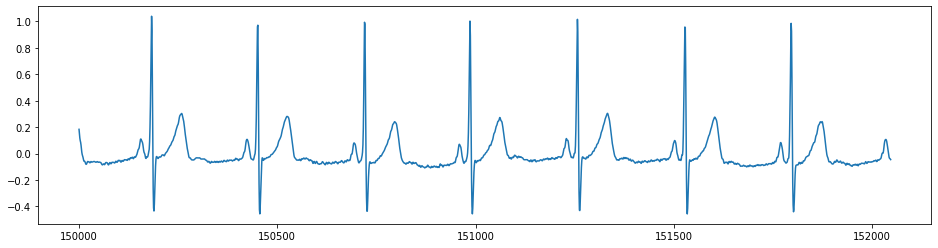

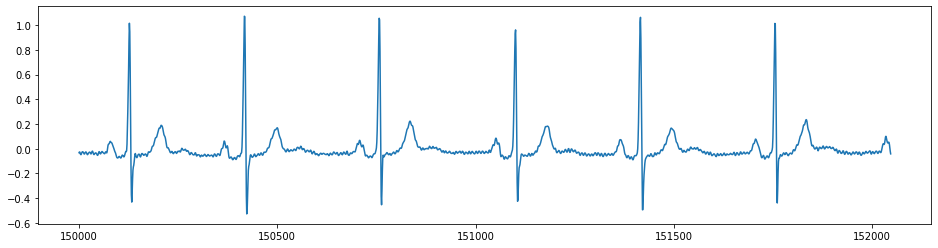

In [8]:
plt.figure(figsize=(16,4))
plt.plot(dataset['sel16272_0'][150000:152048])
plt.figure(figsize=(16,4))
plt.plot(dataset['sel123_0'][150000:152048])

In [9]:
k1 = 'sel16272_0'
k2 = 'sel123_0'

w = 10

for i,(on_from,off_from) in enumerate(zip(Ton[k1],Toff[k1])):
    left_from = np.copy(dataset[k1][on_from-w:on_from].values)
    signal_from = np.copy(dataset[k1][on_from:off_from].values)
    right_from = np.copy(dataset[k1][off_from:off_from+w].values)
    
    for j,(on_to,off_to) in enumerate(zip(Ton[k2],Toff[k2])):
        left_to = np.copy(dataset[k2][on_to-w:on_to].values)
        signal_to = np.copy(dataset[k2][on_to:off_to].values)
        right_to = np.copy(dataset[k2][off_to:off_to+w].values)
        
        if signal_from.size <= signal_to.size:
            signal_to2 = np.copy(signal_to)
            signal_from2 = sak.signal.interpolate.interp1d(signal_from,signal_to)
        else: 
            signal_to2 = sak.signal.interpolate.interp1d(signal_to,signal_from)
            signal_from2 = np.copy(signal_from)
        
        # Append left and right
        signal_from2 = np.concatenate((left_from,signal_from2,right_from))
        signal_to2 = np.concatenate((left_to,signal_to2,right_to))
        
        # Scale and stuff
        signal_from2 = sak.data.ball_scaling(sak.signal.on_off_correction(signal_from2),metric=sak.signal.abs_max)
        signal_to2 = sak.data.ball_scaling(sak.signal.on_off_correction(signal_to2),metric=sak.signal.abs_max)
        break
    break

In [10]:
windowed_to = skimage.util.view_as_windows(dataset[k2].values[validity[k2][0]:validity[k2][1]],signal_from.size)

In [11]:
windowed_to = skimage.util.view_as_windows(dataset[k2].values[validity[k2][0]:validity[k2][1]],signal_from.size)

correlations = np.zeros((windowed_to.shape[0],))
lags = np.zeros((windowed_to.shape[0],),dtype=int)

for i,w in enumerate(tqdm.tqdm(windowed_to)):
    signal_from2 = sak.data.ball_scaling(sak.signal.on_off_correction(signal_from),metric=sak.signal.abs_max)
    w2 = sak.data.ball_scaling(sak.signal.on_off_correction(w),metric=sak.signal.abs_max)
    c,l = sak.signal.xcorr(signal_from2,w2)
    correlations[i] = c[l == 0]
#     lags[i] = l[np.argmax(c)]

100%|██████████| 9089/9089 [00:01<00:00, 8595.81it/s]


In [12]:
places = []

for on,off in zip(*sak.signal.get_mask_boundary(correlations>0.98)):
    if on!=off:
        places.append((np.max(correlations[on:off]),signal_from.size//2+on+np.argmax(correlations[on:off])))

In [14]:
import multiprocessing

In [15]:
multiprocessing.Pool(4)

<multiprocessing.pool.Pool state=RUN pool_size=4>

Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/usr/lib/python3.8/multiprocessing/proces

In [87]:
# Hyperparams
threshold = 0.99

onsets = {}
offsets = {}
for k1 in dataset:
    for i,(on_from,off_from) in enumerate(zip(Ton[k1],Toff[k1])):
        print("{}###{}".format(k1,i))
        signal_from = np.copy(dataset[k1][on_from:off_from].values)
        signal_from = sak.data.ball_scaling(sak.signal.on_off_correction(signal_from),metric=sak.signal.abs_max)
        
        for j,k2 in enumerate(tqdm.tqdm(dataset,total=len(dataset.T))):
            if (k1 == k2):
                continue

            # Retrieve data
            target_onset = Ton[k2]-validity[k2][0]
            target_offset = Toff[k2]-validity[k2][0]

            # Return windowed view
            windowed_k2 = skimage.util.view_as_windows(dataset[k2].values[validity[k2][0]:validity[k2][1]],signal_from.size)

            # Compute correlations
            correlations = []
            for w in windowed_k2:
                w = sak.data.ball_scaling(sak.signal.on_off_correction(w),metric=sak.signal.abs_max)
                c,l = sak.signal.xcorr(signal_from,w)
                correlations.append(c[l == 0])

            # Predict mask
            mask = np.array(correlations) > threshold
            mask = cv2.morphologyEx(mask.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
            predicted_onset = []
            predicted_offset = []
            for on,off in zip(*sak.signal.get_mask_boundary(mask)):
                if on!=off:
                    predicted_onset.append(on+np.argmax(correlations[on:off]))
                    predicted_offset.append(on+np.argmax(correlations[on:off])+signal_from.size)
            if len(predicted_onset) != 0:
                _,_,_,_,on,off = src.metrics.compute_metrics(predicted_onset,predicted_offset,target_onset,target_offset)
            else:
                on = np.array([])
                off = np.array([])
            onsets['{}###{} -> {}'.format(k1,i,k2)] = on
            offsets['{}###{} -> {}'.format(k1,i,k2)] = off


  0%|          | 0/210 [00:00<?, ?it/s]

sel100_0###0


  0%|          | 0/210 [00:00<?, ?it/s]

sel100_0###1


 15%|█▍        | 31/210 [00:16<01:33,  1.91it/s]


KeyboardInterrupt: 

In [74]:
for i,(on_from,off_from) in enumerate(tqdm.tqdm(zip(wave_on[k1],wave_off[k1]))):
    if i == j: continue
    sig_from = np.copy(dataset[k1][on_from:off_from].values)
        
    # Retrieve signal from DB
    whole_signal = dataset[k1].values[validity[k1][0]:validity[k1][1]]
    
    # Return windowed k1
    windowed_k1 = skimage.util.view_as_windows(whole_signal,signal_from.size)

    # Compute correlations
    correlations = []
    for w in windowed_k1:
        w = sak.data.ball_scaling(sak.signal.on_off_correction(w),metric=sak.signal.abs_max)
        c,l = sak.signal.xcorr(signal_from,w)
        correlations.append(c[l == 0])

    # Predict mask
    mask = np.array(correlations) > threshold
    mask = cv2.morphologyEx(mask.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
    predicted_onset = []
    predicted_offset = []
    for on,off in zip(*sak.signal.get_mask_boundary(mask)):
        if on!=off:
            predicted_onset.append(on+np.argmax(correlations[on:off]))
            predicted_offset.append(on+np.argmax(correlations[on:off])+signal_from.size)


30it [00:18,  1.65it/s]


In [69]:
windowed_k1.shape

(9095, 56)

In [653]:
def get_fundamentals(signal: np.ndarray, target_onset: np.ndarray, target_offset: np.ndarray, threshold: float = 0.99):
    selected = np.zeros((target_onset.size,),dtype=bool)
    fundamentals = []
    modifiers_onset = []
    modifiers_offset = []

    for i,(on_sig,off_sig) in enumerate(zip(target_onset,target_offset)):
        if selected[i]: continue
        sig = signal[on_sig:off_sig]
        sig = sak.data.ball_scaling(sak.signal.on_off_correction(sig),metric=sak.signal.abs_max)

        # Compute correlations
        correlations = []
        for j in range(0,signal.size-sig.size):
            w = signal[j:j+sig.size]
            w = sak.data.ball_scaling(sak.signal.on_off_correction(w),metric=sak.signal.abs_max)
            c,l = sak.signal.xcorr(sig,w)
            correlations.append(c[l == 0])

        # Predict mask
        mask = np.array(correlations) > threshold
        mask = cv2.morphologyEx(mask.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
        input_onset = []
        input_offset = []
        for on,off in zip(*sak.signal.get_mask_boundary(mask)):
            if on != off:
                input_onset.append(on+np.argmax(correlations[on:off]))
                input_offset.append(on+np.argmax(correlations[on:off])+sig.size)
            else:
                input_onset.append(on)
                input_offset.append(on+sig.size)
        input_onset = np.array(input_onset)
        input_offset = np.array(input_offset)

        # Compute metrics
        filt = src.metrics.correspondence(input_onset,input_offset,target_onset,target_offset)
        # Do not use the already selected
        filt[:,selected] = False
        # Refine false positives
        filt_fp_targ = filt.sum(0) > 1
        for loc_targ in np.where(filt_fp_targ)[0]:
            # Locate all the correspondent positives (tp and fp)
            filt_fp_inpt = filt[:,loc_targ].squeeze()
            # Localize which is the true positive (smallest distance to true onset)
            loc_inpt = np.where(filt_fp_inpt)[0][np.argmin(np.abs(input_onset[filt_fp_inpt]-target_onset[loc_targ]))]
            # Mark the TP
            filt[:,loc_targ] = False
            filt[loc_inpt,loc_targ] = True
        # Refine false negatives
        filt_fn_inpt = filt.sum(1) > 1
        for loc_inpt in np.where(filt_fn_inpt)[0]:
            # Locate all the correspondent positives (tp and fn)
            filt_fn_targ = filt[loc_inpt,:].squeeze()
            # Localize which is the true positive (smallest distance to true onset)
            loc_targ = np.where(filt_fn_targ)[0][np.argmin(np.abs(target_onset[filt_fn_targ]-input_onset[loc_inpt]))]
            # Mark the TP
            filt[loc_inpt,:] = False
            filt[loc_inpt,loc_targ] = True

        # Retrieve 
        filt_0 = np.any(filt,axis=0)
        filt_1 = np.any(filt,axis=1)

        # Mark selected
        selected[filt_0] = True

        # Retrieve signal related to correlation matches
        target_len = int(np.median(input_offset[filt_1]-input_onset[filt_1]))
        fundamentals.append(sak.signal.interpolate.interp1d(sig,target_len))
        modifiers_onset.append(target_onset[filt_0]-input_onset[filt_1])
        modifiers_offset.append(target_offset[filt_0]-input_offset[filt_1])

    return fundamentals, modifiers_onset, modifiers_offset



threshold = 0.99
sigs = {}
mods_on = {}
mods_off = {}

for k1 in tqdm.tqdm(dataset,total=dataset.shape[1]):
    # Retrieve signal from DB
    signal = np.copy(dataset[k1].values[validity[k1][0]:validity[k1][1]])
        
    # Retrieve data
    target_onset,target_offset = src.metrics.filter_valid(wave_on[k1],wave_off[k1],validity[k1][0],validity[k1][1])-validity[k1][0]

    # Retrieve & store fundamentals
    sigs[k1],mods_on[k1],mods_off[k1] = get_fundamentals(signal,target_onset,target_offset,)

In [665]:
names = ["{}-{}".format(k,i) for k in dataset for i in range(len(QRSon[k]))]

In [669]:
name = np.random.choice(names)

In [843]:
%%time
k1,i = name.split('-')
i = int(i)

signal_k1 = np.copy(dataset[k1].values[validity[k1][0]:validity[k1][1]])

for wave in ['P', 'QRS', 'T']:
    # Retrieve waves
    wave_on = eval("{}on".format(wave))
    wave_off = eval("{}off".format(wave))
    
    # Retrieve fundamental
    if i >= len(wave_on[k1]): continue
    fundamental = dataset[k1][wave_on[k1][i]:wave_off[k1][i]].values
    fundamental = sak.signal.on_off_correction(fundamental)
    
    for j,k2 in enumerate(tqdm.tqdm(dataset,total=dataset.shape[1])):
        if k2 not in wave_on: continue
        # Retrieve data
        target_onset,target_offset = src.metrics.filter_valid(wave_on[k2],wave_off[k2],validity[k2][0],validity[k2][1])-validity[k2][0]
        
        # Retrieve signal
        signal = np.copy(dataset[k2].values[validity[k2][0]:validity[k2][1]])
            
        # Obtain windowing
        windowed_k2 = skimage.util.view_as_windows(signal,fundamental.size)
        filt = np.zeros((windowed_k2.shape[0],),dtype=bool)
        for on,off in zip(target_onset-(fundamental.size+1),target_offset+(fundamental.size-1)):
            filt[on:off] = True

        # Compute correlations
        correlations = np.zeros((windowed_k2.shape[0],))
        for on,w in enumerate(windowed_k2):
            if not filt[on]: continue
            # Correct deviations w.r.t zero
            w = sak.signal.on_off_correction(w)
            c,_ = sak.signal.xcorr(fundamental,w,maxlags=0)
            correlations[on] = c

        # Predict mask - threshold 95%
        mask95 = np.array(correlations) > 0.95
        mask95 = cv2.morphologyEx(mask95.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
        input_onset95 = []
        input_offset95 = []
        for on,off in zip(*sak.signal.get_mask_boundary(mask95)):
            if on!=off:
                input_onset95.append(on+np.argmax(correlations[on:off]))
                input_offset95.append(on+np.argmax(correlations[on:off])+fundamental.size)
        input_onset95 = np.array(input_onset95,dtype=int)
        input_offset95 = np.array(input_offset95,dtype=int)
        
        # Predict mask - threshold 99%
        mask99 = np.array(correlations) > 0.99
        mask99 = cv2.morphologyEx(mask99.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
        input_onset99 = []
        input_offset99 = []
        for on,off in zip(*sak.signal.get_mask_boundary(mask99)):
            if on!=off:
                input_onset99.append(on+np.argmax(correlations[on:off]))
                input_offset99.append(on+np.argmax(correlations[on:off])+fundamental.size)
        input_onset99 = np.array(input_onset99,dtype=int)
        input_offset99 = np.array(input_offset99,dtype=int)
        
        # Obtain the onsets and offses for the different correlations
        _,_,_,_,on95,off95 = src.metrics.compute_metrics(input_onset95,input_offset95,target_onset,target_offset)
        _,_,_,_,on99,off99 = src.metrics.compute_metrics(input_onset99,input_offset99,target_onset,target_offset)
        
        # Save files
        pd.DataFrame({"onset": on95,"offset": off95}).to_csv("./tmp/{}-{}-{}-{}-95".format(k1,i,k2,wave))
        pd.DataFrame({"onset": on99,"offset": off99}).to_csv("./tmp/{}-{}-{}-{}-99".format(k1,i,k2,wave))
        pd.DataFrame({"correlations": correlations}).to_csv("./tmp/{}-{}-{}-{}-correlations".format(k1,i,k2,wave))


100%|██████████| 200/200 [01:04<00:00,  3.10it/s]

CPU times: user 1min 57s, sys: 680 ms, total: 1min 57s
Wall time: 1min 58s


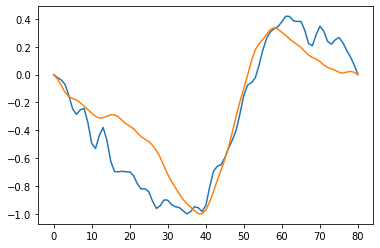

In [778]:
a = -1
plt.plot(fundamental)
plt.plot(sak.data.ball_scaling(sak.signal.on_off_correction(signal[input_onset95[a]:input_offset95[a]]),metric=sak.signal.abs_max))

In [730]:
input_onset95
input_offset95

array([ 174,  380,  587,  793, 1000, 1207, 1412, 1621, 2039])

In [ ]:
plt.plot()

In [725]:
c,l = sak.signal.xcorr(fundamental, 0.1*fundamental)
print(c[l==0])

[1.]


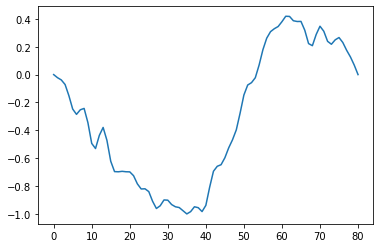

In [720]:
plt.plot(fundamental)

In [716]:
input_onset

[1267, 4915]

In [699]:
{'{}-{}-{}.{}{}'.format(k1,i,k2,wave,"on"): on}

{'sele0104_0-10-sel100_0.Pon': array([], dtype=float64)}

'sel100_0'

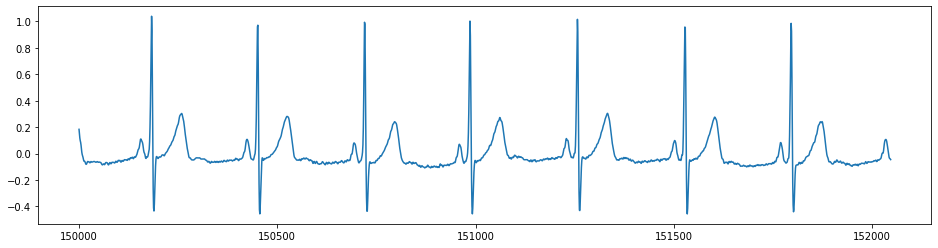

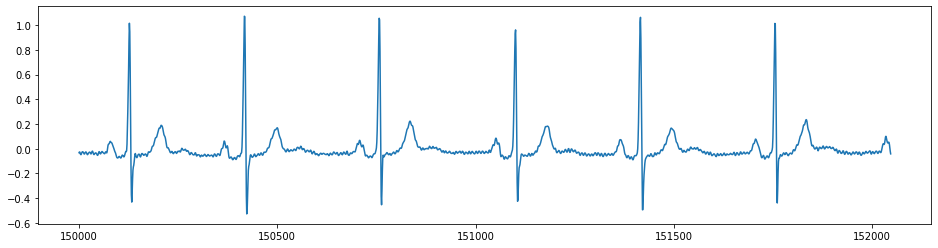

In [7]:
plt.figure(figsize=(16,4))
plt.plot(dataset['sel16272_0'][150000:152048])
plt.figure(figsize=(16,4))
plt.plot(dataset['sel123_0'][150000:152048])

In [668]:
names

['sel100_0-0',
 'sel100_0-1',
 'sel100_0-2',
 'sel100_0-3',
 'sel100_0-4',
 'sel100_0-5',
 'sel100_0-6',
 'sel100_0-7',
 'sel100_0-8',
 'sel100_0-9',
 'sel100_0-10',
 'sel100_0-11',
 'sel100_0-12',
 'sel100_0-13',
 'sel100_0-14',
 'sel100_0-15',
 'sel100_0-16',
 'sel100_0-17',
 'sel100_0-18',
 'sel100_0-19',
 'sel100_0-20',
 'sel100_0-21',
 'sel100_0-22',
 'sel100_0-23',
 'sel100_0-24',
 'sel100_0-25',
 'sel100_0-26',
 'sel100_0-27',
 'sel100_0-28',
 'sel100_0-29',
 'sel100_1-0',
 'sel100_1-1',
 'sel100_1-2',
 'sel100_1-3',
 'sel100_1-4',
 'sel100_1-5',
 'sel100_1-6',
 'sel100_1-7',
 'sel100_1-8',
 'sel100_1-9',
 'sel100_1-10',
 'sel100_1-11',
 'sel100_1-12',
 'sel100_1-13',
 'sel100_1-14',
 'sel100_1-15',
 'sel100_1-16',
 'sel100_1-17',
 'sel100_1-18',
 'sel100_1-19',
 'sel100_1-20',
 'sel100_1-21',
 'sel100_1-22',
 'sel100_1-23',
 'sel100_1-24',
 'sel100_1-25',
 'sel100_1-26',
 'sel100_1-27',
 'sel100_1-28',
 'sel100_1-29',
 'sel102_0-0',
 'sel102_0-1',
 'sel102_0-2',
 'sel102_0-3',


In [32]:
wave_on = Ton
wave_off = Toff


# Select fundamentals

onsets = {}
offsets = {}
for i,(on_from,off_from) in enumerate(zip(wave_on[k1],wave_off[k1])):
    signal_from = np.copy(dataset[k1][on_from:off_from].values)
    signal_from = sak.data.ball_scaling(sak.signal.on_off_correction(signal_from),metric=sak.signal.abs_max)

    for j,k2 in enumerate(tqdm.tqdm(dataset,total=len(dataset.T))):
        if (k1 == k2) or (k2.split('_')[0] in ['sel35','sel36','sel103','sel232','sel310']):
            continue

        # Retrieve data
        target_onset = wave_on[k2]-validity[k2][0]
        target_offset = wave_off[k2]-validity[k2][0]

        # Return windowed view
        windowed_k2 = skimage.util.view_as_windows(dataset[k2].values[validity[k2][0]:validity[k2][1]],signal_from.size)

        # Compute correlations
        correlations = []
        for w in windowed_k2:
            w = sak.data.ball_scaling(sak.signal.on_off_correction(w),metric=sak.signal.abs_max)
            c,l = sak.signal.xcorr(signal_from,w)
            correlations.append(c[l == 0])

        # Predict mask
        mask = np.array(correlations) > threshold
        mask = cv2.morphologyEx(mask.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
        
        # Retrieve fiducials
        predicted_onset = []
        predicted_offset = []
        for on,off in zip(*sak.signal.get_mask_boundary(mask)):
            if on!=off:
                predicted_onset.append(on+np.argmax(correlations[on:off]))
                predicted_offset.append(on+np.argmax(correlations[on:off])+signal_from.size)
        predicted_onset = np.array(predicted_onset)
        predicted_offset = np.array(predicted_offset)
        
        # Compute metrics
        if len(predicted_onset) != 0:
            _,_,_,_,on,off = src.metrics.compute_metrics(predicted_onset,predicted_offset,target_onset,target_offset)
        else:
            on = np.array([])
            off = np.array([])
        onsets['{}###{} -> {}'.format(k1,i,k2)] = on
        offsets['{}###{} -> {}'.format(k1,i,k2)] = off


 60%|██████    | 121/200 [00:55<00:36,  2.17it/s]


KeyboardInterrupt: 

In [33]:
onsets

{'sel16272_0###0 -> sel100_0': array([], dtype=float64),
 'sel16272_0###0 -> sel100_1': array([], dtype=float64),
 'sel16272_0###0 -> sel102_0': array([], dtype=float64),
 'sel16272_0###0 -> sel102_1': array([], dtype=float64),
 'sel16272_0###0 -> sel104_0': array([], dtype=float64),
 'sel16272_0###0 -> sel104_1': [0, 1, 2, 4, 4, -1, -2],
 'sel16272_0###0 -> sel114_0': [12,
  11,
  16,
  11,
  13,
  14,
  6,
  7,
  7,
  4,
  11,
  4,
  2,
  8,
  5,
  12,
  2,
  6],
 'sel16272_0###0 -> sel114_1': array([], dtype=float64),
 'sel16272_0###0 -> sel116_0': [15,
  16,
  26,
  21,
  15,
  14,
  17,
  17,
  21,
  14,
  19,
  18,
  20,
  13,
  18,
  18,
  17,
  19,
  22,
  18,
  18,
  17,
  18,
  21,
  20,
  17,
  19,
  17],
 'sel16272_0###0 -> sel116_1': array([], dtype=float64),
 'sel16272_0###0 -> sel117_0': [7,
  7,
  8,
  12,
  10,
  13,
  14,
  15,
  10,
  12,
  10,
  6,
  8,
  5,
  10,
  13,
  9,
  3,
  8,
  12,
  8,
  1,
  11,
  12,
  12,
  12,
  6,
  5,
  4,
  6],
 'sel16272_0###0 -> s

In [28]:
predicted_onset

[3152, 4771, 5364, 5987, 6389, 6786, 6999]

In [30]:
target_onset

array([  53,  262,  471,  689,  895, 1110, 1318, 1522, 1727, 1922, 2066,
       2288, 2525, 2737, 2944, 3152, 3350, 3539, 3736, 3906, 4135, 4358,
       4570, 4772, 4963, 5162, 5366, 5548, 5762, 5991, 6200, 6393, 6590,
       6785, 6997, 7177, 7398])

In [29]:
predicted_offset

[3214, 4833, 5426, 6049, 6451, 6848, 7061]

In [18]:
def compute_correlations(dataset, k1, wave_on, wave_off, validity, threshold=0.99):
    onsets = {}
    offsets = {}
    for i,(on_from,off_from) in enumerate(zip(wave_on[k1],wave_off[k1])):
        signal_from = np.copy(dataset[k1][on_from:off_from].values)
        signal_from = sak.data.ball_scaling(sak.signal.on_off_correction(signal_from),metric=sak.signal.abs_max)

        for j,k2 in enumerate(tqdm.tqdm(dataset,total=len(dataset.T))):
            if (k1 == k2) or (k2.split('_')[0] in ['sel35','sel36','sel103','sel232','sel310']):
                continue

            # Retrieve data
            target_onset = wave_on[k2]-validity[k2][0]
            target_offset = wave_off[k2]-validity[k2][0]

            # Return windowed view
            windowed_k2 = skimage.util.view_as_windows(dataset[k2].values[validity[k2][0]:validity[k2][1]],signal_from.size)

            # Compute correlations
            correlations = []
            for w in windowed_k2:
                w = sak.data.ball_scaling(sak.signal.on_off_correction(w),metric=sak.signal.abs_max)
                c,l = sak.signal.xcorr(signal_from,w)
                correlations.append(c[l == 0])

            # Predict mask
            mask = np.array(correlations) > threshold
            mask = cv2.morphologyEx(mask.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)

            # Retrieve fiducials
            predicted_onset = []
            predicted_offset = []
            for on,off in zip(*sak.signal.get_mask_boundary(mask)):
                if on!=off:
                    predicted_onset.append(on+np.argmax(correlations[on:off]))
                    predicted_offset.append(on+np.argmax(correlations[on:off])+signal_from.size)
            predicted_onset = np.array(predicted_onset)
            predicted_offset = np.array(predicted_offset)

            # Compute metrics
            if len(predicted_onset) != 0:
                _,_,_,_,on,off = src.metrics.compute_metrics(predicted_onset,predicted_offset,target_onset,target_offset)
            else:
                on = np.array([])
                off = np.array([])
            onsets['{}###{} -> {}'.format(k1,i,k2)] = on
            offsets['{}###{} -> {}'.format(k1,i,k2)] = off

    return onsets, offsets

In [19]:
compute_correlations(dataset,k1,Ton,Toff,validity)

  2%|▎         | 5/200 [00:03<02:30,  1.30it/s]


TypeError: list indices must be integers or slices, not tuple

In [34]:
v1 = np.concatenate([np.array(on,dtype=int) for on in onsets.values()])
v2 = np.concatenate([np.array(on,dtype=int) for on in offsets.values()])
print("N: {}\n\nOnsets, mean: {}\nOnsets, STD: {}\n\nOffsets, mean: {}\nOffsets, STD: {}".format(len(onsets),np.mean(v1)*4, np.std(v1)*4, np.mean(v2)*4, np.std(v2)*4))

N: 5493

Onsets, mean: 35.177008491182235
Onsets, STD: 31.663100715134128

Offsets, mean: 15.031569780100153
Offsets, STD: 38.7227658121618


In [74]:
k1

'sel16272_0'

In [73]:
onsets

{'sel104_1': [0, 1, 2, 4, 4, -1, -2],
 'sel114_0': [12, 11, 16, 11, 13, 14, 6, 7, 7, 4, 11, 4, 2, 8, 5, 12, 2, 6],
 'sel116_0': [15,
  16,
  26,
  21,
  15,
  14,
  17,
  17,
  21,
  14,
  19,
  18,
  20,
  13,
  18,
  18,
  17,
  19,
  22,
  18,
  18,
  17,
  18,
  21,
  20,
  17,
  19,
  17],
 'sel117_0': [7,
  7,
  8,
  12,
  10,
  13,
  14,
  15,
  10,
  12,
  10,
  6,
  8,
  5,
  10,
  13,
  9,
  3,
  8,
  12,
  8,
  1,
  11,
  12,
  12,
  12,
  6,
  5,
  4,
  6],
 'sel117_1': [9,
  8,
  9,
  12,
  11,
  14,
  15,
  16,
  11,
  13,
  10,
  7,
  9,
  6,
  12,
  14,
  10,
  3,
  8,
  13,
  9,
  2,
  12,
  13,
  13,
  13,
  7,
  6,
  5,
  8],
 'sel123_0': [13, 15, 17, 12, 13],
 'sel123_1': [13, 15, 17, 18, 15, 9],
 'sel14157_1': [17, 17, 20, 17, 19, 18, 21, 16, 22, 15, 21],
 'sel14172_1': [21,
  23,
  21,
  21,
  22,
  21,
  21,
  23,
  14,
  24,
  17,
  19,
  21,
  18,
  20,
  23,
  23,
  19],
 'sel15814_1': [],
 'sel16265_0': [-5,
  -4,
  -4,
  -2,
  -5,
  -3,
  -5,
  -4,
  -5,
  -

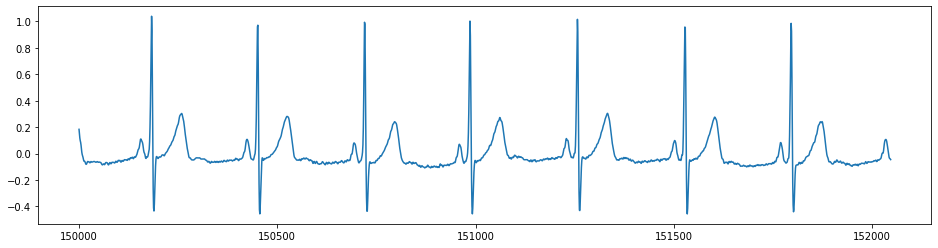

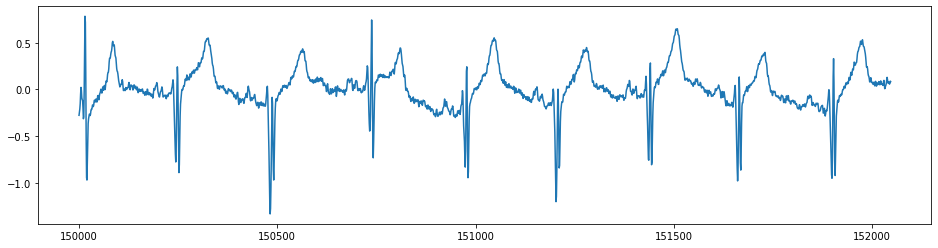

In [76]:
plt.figure(figsize=(16,4))
plt.plot(dataset['sel16272_0'][150000:152048])
plt.figure(figsize=(16,4))
plt.plot(dataset['sel114_0'][150000:152048])

In [70]:
np.mean(v)*4

49.20796460176991

In [71]:
np.std(v)*4

27.069741594933006

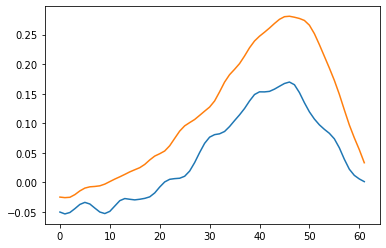

In [182]:
plt.plot(dataset[k2].values[validity[k2][0]:validity[k2][1]][predicted_onset[0]:predicted_offset[0]])
plt.plot(signal_from)

In [33]:
from dtaidistance import dtwa
from dtaidistance import dtw_visualisation as dtwvis

(<Figure size 432x288 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

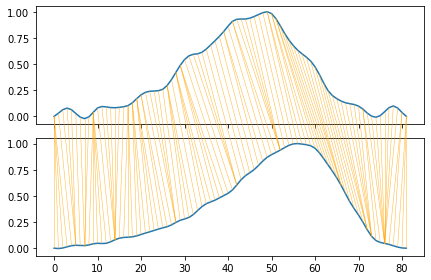

In [34]:
path = dtw.warping_path(signal_to2,signal_from2)
dtwvis.plot_warping(signal_to2,signal_from2,path)

In [35]:
path

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 4),
 (2, 5),
 (3, 5),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 7),
 (8, 7),
 (9, 8),
 (9, 9),
 (9, 10),
 (9, 11),
 (9, 12),
 (10, 13),
 (11, 14),
 (12, 14),
 (13, 14),
 (14, 14),
 (15, 14),
 (16, 15),
 (17, 16),
 (17, 17),
 (17, 18),
 (18, 19),
 (18, 20),
 (18, 21),
 (19, 22),
 (19, 23),
 (19, 24),
 (20, 25),
 (20, 26),
 (21, 27),
 (22, 28),
 (23, 28),
 (24, 28),
 (25, 29),
 (26, 30),
 (26, 31),
 (26, 32),
 (27, 33),
 (28, 34),
 (28, 35),
 (28, 36),
 (29, 37),
 (29, 38),
 (29, 39),
 (30, 40),
 (31, 41),
 (32, 42),
 (33, 42),
 (34, 42),
 (35, 43),
 (36, 44),
 (37, 45),
 (38, 46),
 (39, 47),
 (39, 48),
 (40, 49),
 (41, 50),
 (41, 51),
 (42, 52),
 (43, 52),
 (44, 52),
 (45, 52),
 (46, 53),
 (47, 54),
 (48, 55),
 (49, 56),
 (49, 57),
 (50, 58),
 (50, 59),
 (51, 60),
 (51, 61),
 (52, 62),
 (53, 63),
 (54, 64),
 (55, 65),
 (56, 66),
 (57, 66),
 (58, 66),
 (59, 67),
 (60, 68),
 (61, 69),
 (62, 70),
 (63, 71),
 (64, 72),
 (65, 72),
 (66, 72),
 (67, 73),
 (68, 73

In [ ]:
sak.singal.in

In [168]:
isinstance(dataset[k],pd.Series)

True

In [148]:
signal_from.size

82

In [149]:
signal_to2 = sp.interpolate.interp1d(np.linspace(0,1,signal_to.size),signal_to)(np.linspace(0,1,signal_from.size))

In [150]:
c,l = sak.signal.xcorr(signal_from,signal_to2)

In [151]:
c.max()

0.9617207327370974

In [152]:
print("c: {}, l[c]: {}".format(np.round(np.max(c)*100,2),l[np.argmax(c)]))

c: 96.17, l[c]: -5


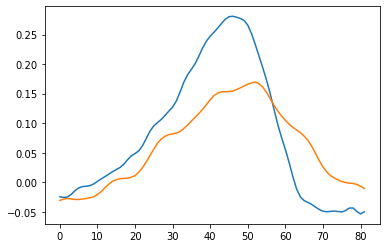

In [153]:
plt.plot(signal_from)
plt.plot(signal_to2)

In [112]:
l[np.argmax(c)]

7

In [47]:
signal_to

array([-0.03475009, -0.02704306, -0.01680019, -0.01165223, -0.00812216,
       -0.0010372 ,  0.00595306,  0.00998994,  0.01816627,  0.03346413,
        0.04395638,  0.04255283,  0.042603  ,  0.05473403,  0.06533882,
        0.05940042,  0.04763935,  0.04881166,  0.06010463,  0.06623751,
        0.06417381,  0.0591281 ,  0.0483758 ,  0.0267195 , -0.00012207,
       -0.02004438])

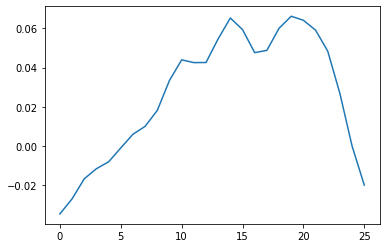

In [44]:
plt.plot(signal)

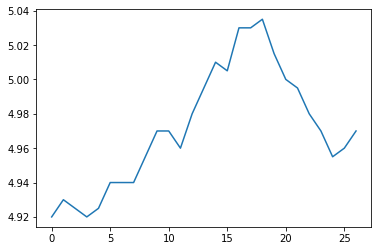

In [17]:
plt.plot(dataset[k][on:off].values)

In [13]:
off

150552

# Check file

In [101]:
# Store as simple variables
basedir = '/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/'
outdir = '/media/guille/DADES/DADES/PhysioNet/QTDB/manual0/bias/'
signal_id = 1719
win_size = 20

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ LOAD DATASET ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("LOAD DATASET")
# Dataset
dataset = pd.read_csv(os.path.join(basedir,'Dataset.csv'), index_col=0)
dataset = dataset.sort_index(axis=1)

# Validity
try:
    validity = sak.load_data(os.path.join(basedir,'validity.csv'))
    appendage = "New"
    # Convert to old-style format
    val_tmp = {}
    for k in validity:
        val_tmp[k] = {}
        val_tmp[k]["on"] = [validity[k][0]]
        val_tmp[k]["off"] = [validity[k][1]]
    for k in ['sel35','sel36','sel103','sel232','sel310']:
        val_tmp[k+'_0'] = {}
        val_tmp[k+'_1'] = {}
        val_tmp[k+'_0']["on"] = []
        val_tmp[k+'_1']["on"] = []
        val_tmp[k+'_0']["off"] = []
        val_tmp[k+'_1']["off"] = []
    validity = pd.DataFrame(val_tmp)

except FileNotFoundError:
    validity = pd.read_csv(os.path.join(basedir,'Validity.csv'), index_col=0, 
                        converters={"on": eval, "off": eval}).T
    appendage = ""

# Fiducials
Pon    = sak.load_data(os.path.join(basedir,'Pon{}.csv'.format(appendage)))
Poff   = sak.load_data(os.path.join(basedir,'Poff{}.csv'.format(appendage)))
QRSon  = sak.load_data(os.path.join(basedir,'QRSon{}.csv'.format(appendage)))
QRSoff = sak.load_data(os.path.join(basedir,'QRSoff{}.csv'.format(appendage)))
Ton    = sak.load_data(os.path.join(basedir,'Ton{}.csv'.format(appendage)))
Toff   = sak.load_data(os.path.join(basedir,'Toff{}.csv'.format(appendage)))

# Add all to validity
for k in QRSon:
    if k not in validity:
        validity = validity.to_dict()
        validity[k] = {"on": [], "off": []}
        validity = pd.DataFrame(validity)

# Exclude validity sections smaller than N = 2048
for k in validity:
    exclude = []
    for i,(on,off) in enumerate(zip(*validity[k])):
        if off-on < 2048:
            exclude.append(i)
    # Sort list
    exclude = np.sort(exclude)[::-1]
    if len(exclude) > 0:
        for pos in exclude:
            validity = validity.to_dict()
            validity[k]["on"].pop(pos)
            validity[k]["off"].pop(pos)
            validity = pd.DataFrame(validity)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ NORMALIZE DATASET ~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("NORMALIZE DATASET")
for k in tqdm.tqdm(list(dataset)):
    if (len(validity[k]['on']) == 0) or (len(validity[k]['off']) == 0):
        continue
    # Copy signal just in case
    signal = np.copy(dataset[k].values)

    # Filter signal
    signal = sp.signal.filtfilt(*sp.signal.butter(4,   0.5/250., 'high'),signal.T).T
    signal = sp.signal.filtfilt(*sp.signal.butter(4, 125.0/250.,  'low'),signal.T).T

    # Normalize and pad signal for inputing in algorithm
    normalization = np.median(sak.signal.moving_lambda(signal,256,sak.signal.abs_max))
    signal = signal/normalization

    # Store in dataset
    dataset[k] = signal

# ~~~~~~~~~~~~~~~~~~~~~ RETRIEVE AVAILABLE SIGNAL NAMES ~~~~~~~~~~~~~~~~~~~~
print("RETRIEVE AVAILABLE SIGNAL NAMES")
sig_names = []

for k in QRSon:
    max_n = max([len(Pon[k]),len(QRSon[k]),len(Ton[k])])
    for i in range(max_n):
        sig_names.append("{}-{}".format(k,i))


In [124]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ COMPUTE BIAS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print("COMPUTE BIAS")
# Retrieve 
k1,i = sig_names[signal_id].split('-')
i = int(i)

for wave in ['P', 'QRS', 'T']:
    if wave != 'T': continue
    # Retrieve waves
    wave_on = eval("{}on".format(wave))
    wave_off = eval("{}off".format(wave))

    # Retrieve fundamental
    if i >= len(wave_on[k1]): continue
    # Onset and offset comparisons
    fundamental_on  = dataset[k1][wave_on[k1][i]-win_size:wave_off[k1][i]].values
    fundamental_on  = sak.signal.on_off_correction(fundamental_on)
    fundamental_off = dataset[k1][wave_on[k1][i]:wave_off[k1][i]+win_size].values
    fundamental_off = sak.signal.on_off_correction(fundamental_off)

    out_wave = {}

    for k2 in tqdm.tqdm(dataset,total=dataset.shape[1]):
        # if the specific wave has nothing for the key, pass
        if k2 not in wave_on: continue

        # Define output structures
        onsets95 = []
        offsets95 = []
        onsets99 = []
        offsets99 = []
        correlations = []

        for valid_on,valid_off in zip(*validity[k2]):
            # Retrieve data
            target_onset,target_offset = src.metrics.filter_valid(wave_on[k2],wave_off[k2],valid_on,valid_off)
            target_onset -= valid_on
            target_offset -= valid_on

            # Skip if no available target delineations
            if target_onset.size == 0: continue

            # Retrieve signal
            signal = np.copy(dataset[k2].values[valid_on:valid_off])

            # Obtain windowing
            windowed_k2_on  = skimage.util.view_as_windows(signal,fundamental_on.size)
            windowed_k2_off = skimage.util.view_as_windows(signal,fundamental_off.size)
            filt_on = np.zeros((windowed_k2_on.shape[0],),dtype=bool)
            filt_off  = np.zeros((windowed_k2_off.shape[0],),dtype=bool)
            for on,off in zip(target_onset-(fundamental_on.size+1),target_offset+(fundamental_on.size-1)):
                filt_on[on:off]  = True
            for on,off in zip(target_onset-(fundamental_off.size+1),target_offset+(fundamental_off.size-1)):
                filt_off[on:off] = True

            # Compute correlations
            corrs_on  = np.zeros((windowed_k2_on.shape[0],))
            corrs_off = np.zeros((windowed_k2_off.shape[0],))
            for j in range(len(windowed_k2_on)):
                if filt_on[j]:
                    # Correct deviations w.r.t zero
                    w = sak.signal.on_off_correction(windowed_k2_on[j])
                    c,_ = sak.signal.xcorr(fundamental_on,w,maxlags=0)
                    corrs_on[j] = c
                if filt_off[j]:
                    # Correct deviations w.r.t zero
                    w = sak.signal.on_off_correction(windowed_k2_off[j])
                    c,_ = sak.signal.xcorr(fundamental_off,w,maxlags=0)
                    corrs_off[j] = c

            # Predict mask - threshold 95%
            mask95_on  = np.array(corrs_on) > 0.95
            mask95_off = np.array(corrs_off) > 0.95
            mask95_on  = cv2.morphologyEx(mask95_on.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
            mask95_off = cv2.morphologyEx(mask95_off.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
            input_onset95 = []
            input_offset95 = []
            for on,off in zip(*sak.signal.get_mask_boundary(mask95_on)):
                if on != off: added_samples = np.argmax(corrs_on[on:off])
                else:         added_samples = 0
                input_onset95.append(on+added_samples+win_size)
            for on,off in zip(*sak.signal.get_mask_boundary(mask95_off)):
                if on != off: added_samples = np.argmax(corrs_off[on:off])
                else:         added_samples = 0
                input_offset95.append(on+added_samples+(fundamental_off.size-win_size))
            input_onset95 = np.array(input_onset95,dtype=int)
            input_offset95 = np.array(input_offset95,dtype=int)

            # Predict mask - threshold 99%
            mask99_on  = np.array(corrs_on) > 0.99
            mask99_off = np.array(corrs_off) > 0.99
            mask99_on  = cv2.morphologyEx(mask99_on.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
            mask99_off = cv2.morphologyEx(mask99_off.astype(float), cv2.MORPH_CLOSE, np.ones((11,))).squeeze().astype(bool)
            input_onset99 = []
            input_offset99 = []
            for on,off in zip(*sak.signal.get_mask_boundary(mask99_on)):
                if on != off: added_samples = np.argmax(corrs_on[on:off])
                else:         added_samples = 0
                input_onset99.append(on+added_samples+win_size)
            for on,off in zip(*sak.signal.get_mask_boundary(mask99_off)):
                if on != off: added_samples = np.argmax(corrs_off[on:off])
                else:         added_samples = 0
                input_offset99.append(on+added_samples+(fundamental_off.size-win_size))
            input_onset99 = np.array(input_onset99,dtype=int)
            input_offset99 = np.array(input_offset99,dtype=int)

            # Obtain the onsets and offses for the different correlations
            _,_,_,_,on95,_  = src.metrics.compute_metrics(input_onset95,                                  input_onset95+(fundamental_on.size-win_size), target_onset,target_offset)
            _,_,_,_,_,off95 = src.metrics.compute_metrics(input_offset95-(fundamental_off.size-win_size), input_offset95,                               target_onset,target_offset)
            _,_,_,_,on99,_  = src.metrics.compute_metrics(input_onset99,                                  input_onset99+(fundamental_on.size-win_size), target_onset,target_offset)
            _,_,_,_,_,off99 = src.metrics.compute_metrics(input_offset99-(fundamental_off.size-win_size), input_offset99,                               target_onset,target_offset)

            # Add to current structures
            onsets95 += on95
            offsets95 += off95
            onsets99 += on99
            offsets99 += off99
            if len(on99) != 0: gakglksjg
            if k1 == k2: oahgldhsg

        if len(onsets95) != 0:  out_wave[k2+',onsets95']  = onsets95
        if len(offsets95) != 0: out_wave[k2+',offsets95'] = offsets95
        if len(onsets99) != 0:  out_wave[k2+',onsets99']  = onsets99
        if len(offsets99) != 0: out_wave[k2+',offsets99'] = offsets99

#     # Save files
#     out_dir = os.path.join(outdir,k1,"{}_{}.csv".format(wave,i))
#     pathlib.Path(os.path.split(out_dir)[0]).mkdir(parents=True, exist_ok=True) # Make necessary dirs
#     sak.save_data(out_wave, out_dir)


  0%|          | 0/210 [00:00<?, ?it/s]

COMPUTE BIAS


 17%|█▋        | 36/210 [00:23<01:52,  1.55it/s]


NameError: name 'gakglksjg' is not defined

In [129]:
input_onsets = np.copy(input_onset99)
input_offsets = np.copy(input_onset99+(fundamental_on.size-win_size))
target_onsets = np.copy(target_onset)
target_offsets = np.copy(target_offset)

# Init output
tp   = 0
fp   = 0
fn   = 0
dice = 0
onset_error  = []
offset_error = []

# Find correspondence between fiducials
filter = src.metrics.correspondence(input_onsets, input_offsets, target_onsets, target_offsets)

# Check correspondence of GT beats to detected beats
corr  = dict()

# Account for already detected beats to calculate false positives
chosen = np.zeros((filter.shape[0],), dtype=bool)
for i,column in enumerate(filter.T):
    corr[i] = np.where(column)[0]
    chosen = chosen | column

# Retrieve beats detected that do not correspond to any GT beat (potential false positives)
not_chosen = np.where(np.logical_not(chosen))[0]

# Compute Dice coefficient
mask_input  = np.zeros((np.max(np.hstack((input_offsets,target_offsets)))+10,),dtype=bool)
mask_target = np.zeros((np.max(np.hstack((input_offsets,target_offsets)))+10,),dtype=bool)
for (onset,offset) in zip(input_onsets,input_offsets):
    mask_input[onset:offset] = True
for (onset,offset) in zip(target_onsets,target_offsets):
    mask_target[onset:offset] = True
dice = src.metrics.dice_score(mask_input, mask_target)

# Compute metrics - Fusion strategy of results of both leads, following Martinez et al.
for i in range(filter.shape[1]):
    # If any GT beat has a correspondence to any segmented beat, true positive + accounts for on/offset error
    if len(corr[i]) != 0:
        # Mark beat as true positive
        tp += 1

        # Compute the onset-offset errors
        onset_error.append(int(sak.signal.signed_minima(target_onsets[i]  - input_onsets[corr[i]])))
        offset_error.append(int(sak.signal.signed_minima(target_offsets[i] - input_offsets[corr[i]])))

    # If any GT beat has a correspondence to more than one segmented beat, 
    #     the rest of the pairs have to be false positives (Martinez et al.)
    if len(corr[i]) > 1:
        fp += len(corr[i]) - 1

    # If any GT beat has no correspondence to any segmented beat, false negative
    if len(corr[i]) == 0:
        fn += 1

# False positives will correspond to those existing in the results that do not correspond to any beat in the GT (the not chosen)
fp += len(not_chosen)



In [134]:
np.vstack((input_onsets,input_offsets))

array([[ 163,  403,  629, 1071, 1279, 1489, 1962, 2657, 2874, 3097, 3331,
        3557, 3778, 4008, 4923, 5611, 5864, 6103, 6330, 6546, 6758],
       [ 227,  467,  693, 1135, 1343, 1553, 2026, 2721, 2938, 3161, 3395,
        3621, 3842, 4072, 4987, 5675, 5928, 6167, 6394, 6610, 6822]])

In [135]:
np.vstack((target_onsets,target_offsets))

array([[ 162,  404,  628,  852, 1072, 1279, 1488, 1723, 1961, 2194, 2429,
        2661, 2876, 3098, 3329, 3555, 3776, 4006, 4237, 4458, 4686, 4927,
        5151, 5366, 5613, 5865, 6104, 6331, 6548, 6762],
       [ 228,  468,  697,  918, 1135, 1343, 1557, 1791, 2026, 2261, 2496,
        2719, 2938, 3161, 3397, 3623, 3846, 4072, 4300, 4528, 4748, 4991,
        5211, 5433, 5677, 5928, 6170, 6393, 6608, 6824]])

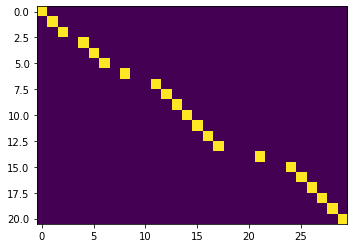

In [132]:
plt.imshow(filter)